In [1]:
!pip install librosa soundfile audiomentations pydub

In [ ]:
import librosa
import librosa.display
import soundfile as sf
from audiomentations import Compose, PitchShift, TimeStretch, AddGaussianNoise, Shift
import os 
import random
import numpy as np
import IPython
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.io import wavfile
 

In [3]:
real_positive_directory = './Dataset/positive_real'
generated_positive_directory = './Dataset/positive_generated'
negative_directory = './Dataset/negatives'
backgrounds_directory = './Dataset/backgrounds'

backgrounds_files = [backgrounds_directory+"/"+f for f in os.listdir(backgrounds_directory) if f.endswith('.wav')]
negative_files = [negative_directory+"/"+f for f in os.listdir(negative_directory) if f.endswith('.wav')]

# Check sample rate of negative and backgrounds

In [4]:
def get_sample_rate(base_path):
    _files = [f for f in os.listdir(base_path) if f.endswith('.wav')]
    sample_rates = []
    for file_name in _files:
        file_path = f"{base_path}/{file_name}"
        _, sr = librosa.load(file_path)
        sample_rates.append(sr)

    sample_rates = list(set(sample_rates))
    return sample_rates


In [5]:
get_sample_rate(negative_directory)

[22050]

In [6]:
get_sample_rate(real_positive_directory)


[22050]

In [7]:
get_sample_rate(backgrounds_directory)


[22050]

# Augment positive samples

In [8]:
real_positive_directory = './Dataset/positive_real'
generated_positive_directory = './Dataset/positive_generated'
wav_files = [f for f in os.listdir(real_positive_directory) if f.endswith('.wav')]
wav_files

['positive_1.wav', 'positive_2.wav', 'positive_3.wav', 'positive_4.wav']

In [9]:

for file_name in wav_files:
    file_path = f"{real_positive_directory}/{file_name}"
    print(f"Augmenting file : {file_path}")
    # Load your original sample
    signal, sr = librosa.load(file_path)
    print(f"Sample rate : {sr}")
    # Define the augmentation pipeline
    #https://pypi.org/project/audiomentations/
    augment = Compose([
        # Changes the "voice" by shifting pitch (n_semitones)
        PitchShift(min_semitones=-6, max_semitones=6, p=1),
        
        # Changes the speed without changing the pitch
        #TimeStretch(min_rate=0.5, max_rate=1.5, p=0.8),
        
        # Shifts the audio forward/backward in time slightly
        #Shift(min_shift=-1, max_shift=1, p=0.8),
        
        # Adds a bit of "real world" background static
        #AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.0015, p=0.5),
    ])

    # Generate 50 variations for this one sample
    base_name = file_name.replace(".wav","")
    for i in range(10):
        random.seed(i) 
        np.random.seed(i)
    
        # Save with the index in the name to prevent overwriting
        augmented_signal = augment(samples=signal, sample_rate=sr)
        sf.write(f"{generated_positive_directory}/{base_name}_{i}.wav", augmented_signal, sr)

Augmenting file : ./Dataset/positive_real/positive_1.wav
Sample rate : 22050
Augmenting file : ./Dataset/positive_real/positive_2.wav
Sample rate : 22050
Augmenting file : ./Dataset/positive_real/positive_3.wav
Sample rate : 22050
Augmenting file : ./Dataset/positive_real/positive_4.wav
Sample rate : 22050


In [10]:
get_sample_rate(generated_positive_directory)

[22050]

# Visual analysis on signal

In [11]:

wav_files = [f"{real_positive_directory}/{f}" for f in os.listdir(real_positive_directory) if f.endswith('.wav')]
wav_files = list(random.sample(wav_files, 2))
files_no_ext = {f.replace(".wav","").split("/")[-1] : [] for f in wav_files}
print("original audio : ",wav_files)
print("original audio  NO ext: ",files_no_ext)

generated_wav_files = [f"{generated_positive_directory}/{f}" for f in os.listdir(generated_positive_directory) if f.endswith('.wav')]
filtered_gen_wav = []
for f in generated_wav_files:
    f_filtered = '_'.join(f.replace(".wav","").split("_")[:-1]).split("/")[-1]
    if f_filtered in files_no_ext:
        files_no_ext[f_filtered].append(f)
files_no_ext


original audio :  ['./Dataset/positive_real/positive_1.wav', './Dataset/positive_real/positive_2.wav']
original audio  NO ext:  {'positive_1': [], 'positive_2': []}


{'positive_1': ['./Dataset/positive_generated/positive_1_0.wav',
  './Dataset/positive_generated/positive_1_1.wav',
  './Dataset/positive_generated/positive_1_2.wav',
  './Dataset/positive_generated/positive_1_3.wav',
  './Dataset/positive_generated/positive_1_4.wav',
  './Dataset/positive_generated/positive_1_5.wav',
  './Dataset/positive_generated/positive_1_6.wav',
  './Dataset/positive_generated/positive_1_7.wav',
  './Dataset/positive_generated/positive_1_8.wav',
  './Dataset/positive_generated/positive_1_9.wav'],
 'positive_2': ['./Dataset/positive_generated/positive_2_6.wav',
  './Dataset/positive_generated/positive_2_0.wav',
  './Dataset/positive_generated/positive_2_1.wav',
  './Dataset/positive_generated/positive_2_2.wav',
  './Dataset/positive_generated/positive_2_3.wav',
  './Dataset/positive_generated/positive_2_4.wav',
  './Dataset/positive_generated/positive_2_5.wav',
  './Dataset/positive_generated/positive_2_7.wav',
  './Dataset/positive_generated/positive_2_8.wav',
  

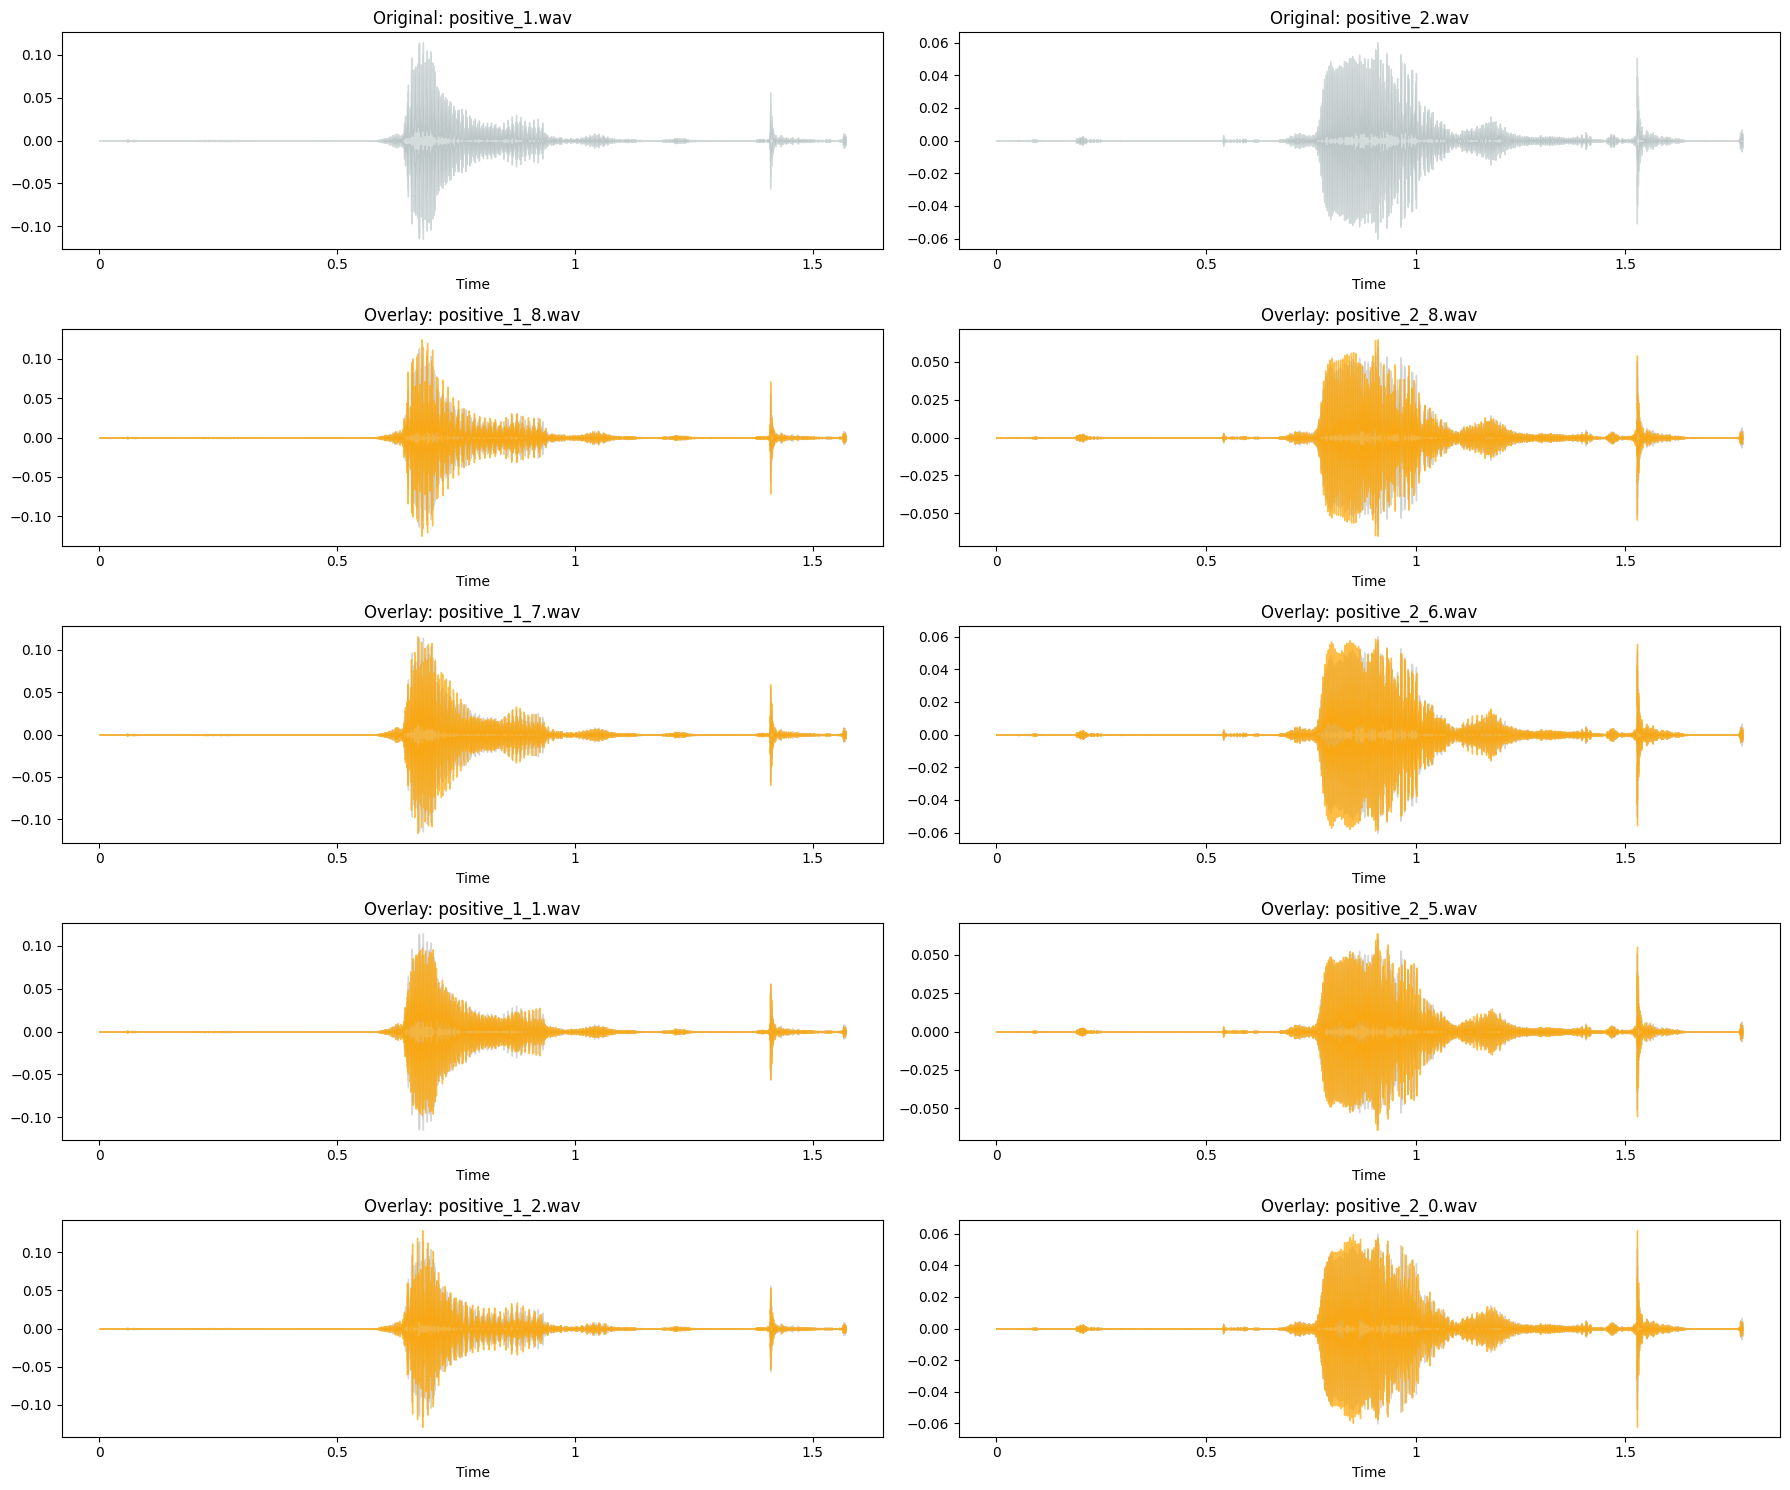

In [12]:
x_axis = 4  # Number of generated samples per original
height = 3 * (x_axis + 1) # Waves are shorter than spectrograms, adjusted height
COLOR_ORIG = '#95a5a6' # Muted Gray (Neutral)
COLOR_GEN  = '#d35400' # Burnt Orange (High Contrast)

# Rows = 1 (Original) + x_axis (Generated), Columns = Number of original files
fig, ax = plt.subplots(x_axis + 1, len(wav_files), figsize=(18, height))

gen_sample_dic = {}

for j, file in enumerate(wav_files):
    # Load Original once for this column
    y_orig, sr = librosa.load(file)
    file_name = file.split("/")[-1]
    
    # 1. Plot the Original in the first row (Top)
    librosa.display.waveshow(y_orig, sr=sr, ax=ax[0, j], color=COLOR_ORIG, alpha=0.4)
    ax[0, j].set_title(f"Original: {file_name}")

    # Get the generated filenames for this specific original
    k = file_name.replace(".wav", "")
    gen_sample_dic[k] = random.sample(files_no_ext[k], x_axis)
    # 2. Plot Overlapped versions in the rows below
    for i_gen, gen_file_path in enumerate(gen_sample_dic[k]):
        row = i_gen + 1
        
        # Load the generated audio
        y_gen, sr = librosa.load(gen_file_path)
        gen_name = gen_file_path.split("/")[-1]

        # --- THE OVERLAP MAGIC ---
        # First, plot the original as a background reference (Gray)
        librosa.display.waveshow(y_orig, sr=sr, ax=ax[row, j], color='gray', alpha=0.3, label='Original')
        
        # Second, plot the generated one on top (Orange/Red)
        librosa.display.waveshow(y_gen, sr=sr, ax=ax[row, j], color='orange', alpha=0.7, label='Augmented')
        
        ax[row, j].set_title(f"Overlay: {gen_name}")
        # -------------------------

fig.tight_layout()
plt.show()

Difference between the signal 

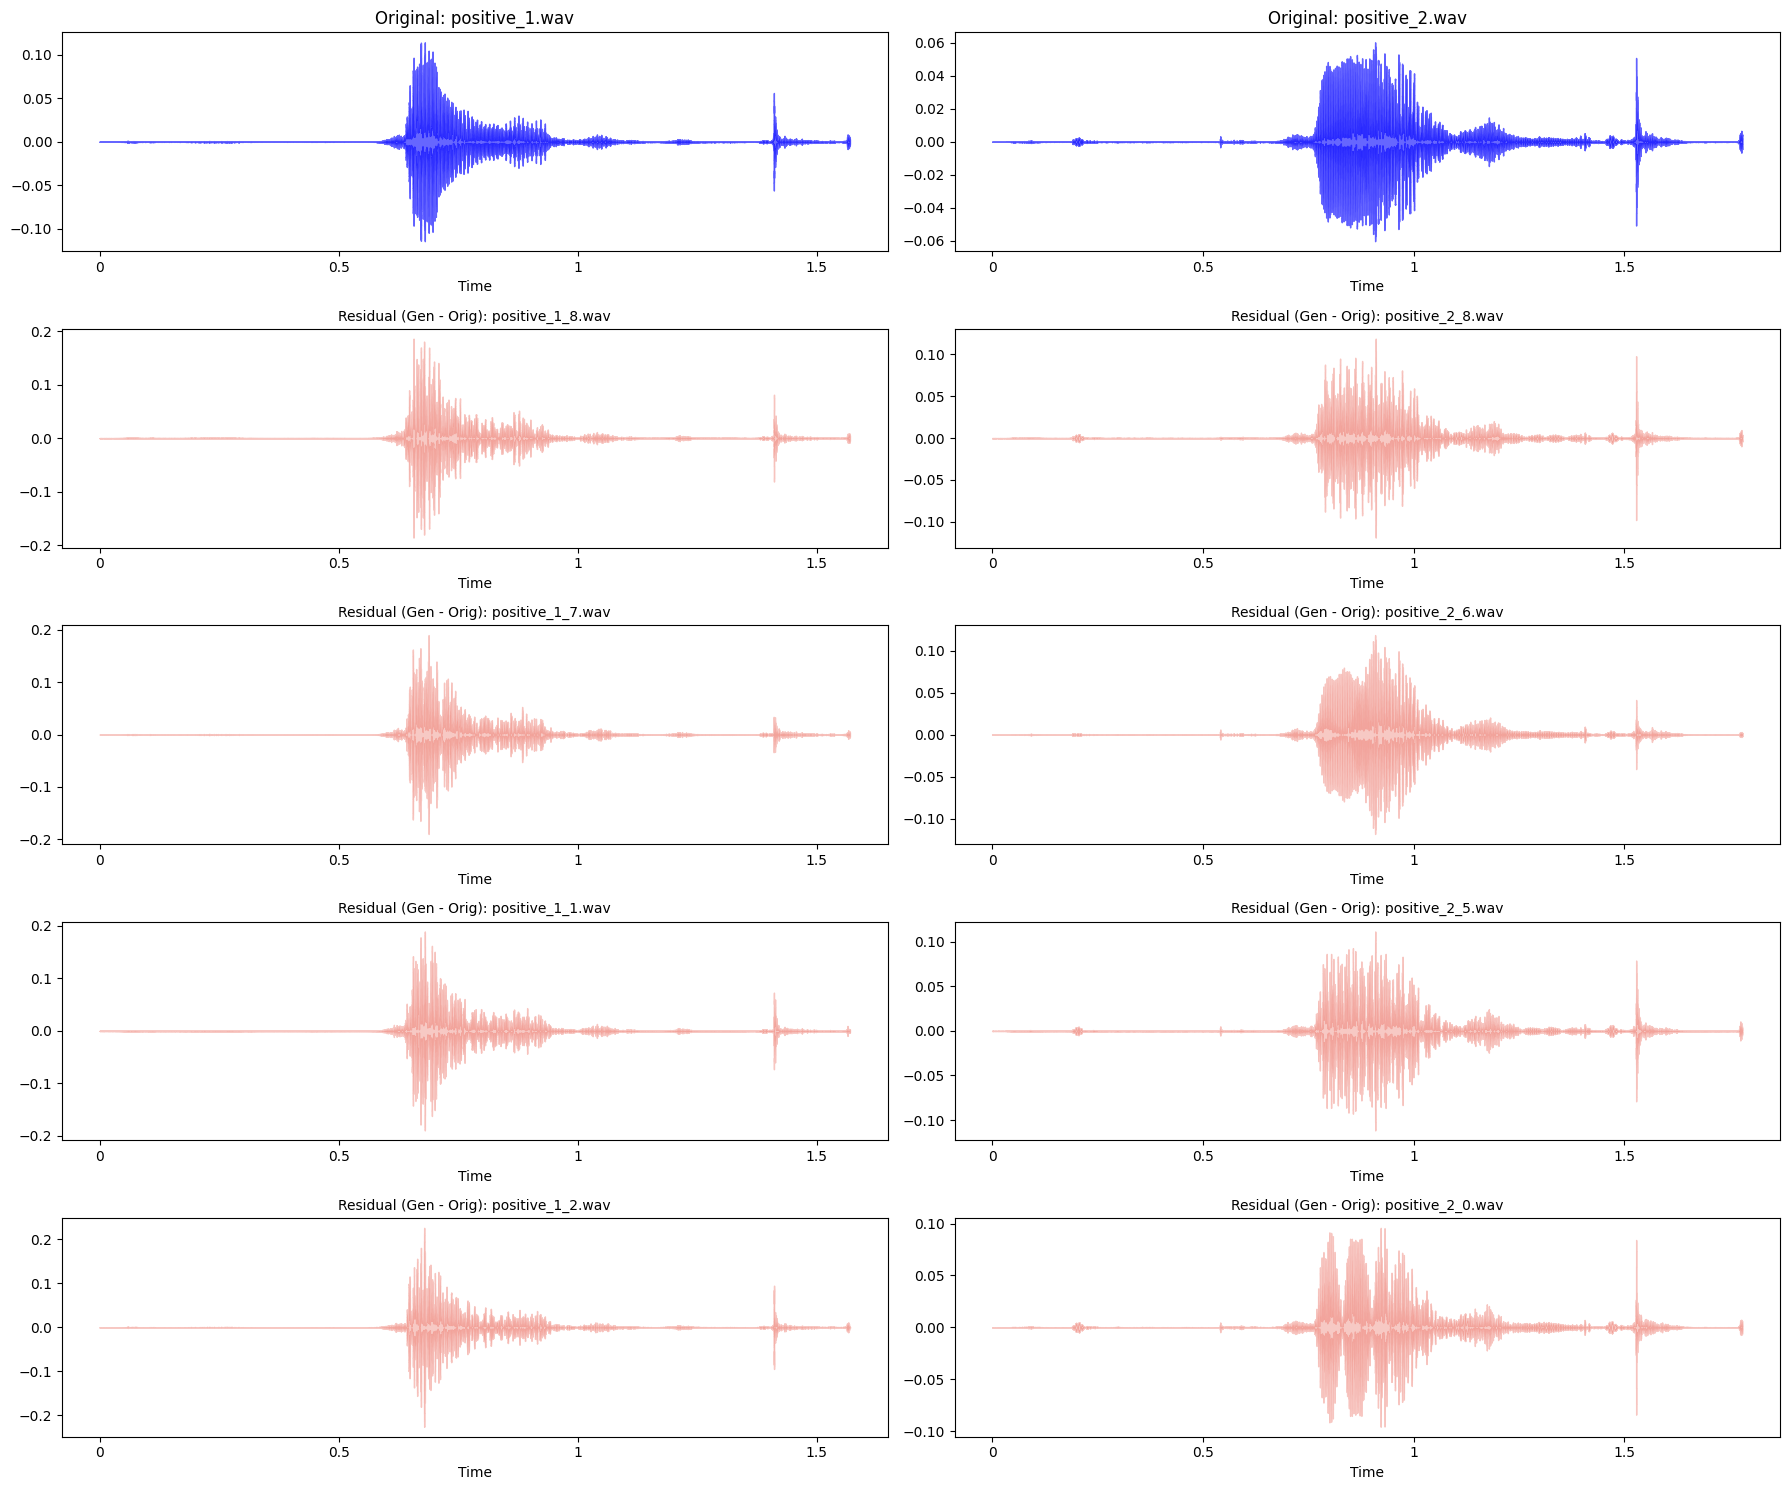

In [13]:
COLOR_DIFF = '#e74c3c' # Red for the difference

# Rows = 1 (Original) + x_axis (Generated Differences), Columns = Number of original files
fig, ax = plt.subplots(x_axis + 1, len(wav_files), figsize=(18, height))

# Fix indexing for single files
if len(wav_files) == 1:
    ax = ax.reshape(-1, 1)

for j, file in enumerate(wav_files):
    y_orig, sr = librosa.load(file)
    file_name = file.split("/")[-1]
    
    # Row 0: Pure Original
    librosa.display.waveshow(y_orig, sr=sr, ax=ax[0, j], color='blue', alpha=0.6)
    ax[0, j].set_title(f"Original: {file_name}")

    k = file_name.replace(".wav", "")

    for i_gen, gen_file_path in enumerate(gen_sample_dic[k]):
        row = i_gen + 1
        y_gen, _ = librosa.load(gen_file_path, sr=sr)
        
        # --- WAVEFORM PADDING/ALIGNMENT ---
        # Find max length to make subtraction possible
        max_len = max(len(y_orig), len(y_gen))
        y_orig_pad = np.pad(y_orig, (0, max_len - len(y_orig)))
        y_gen_pad = np.pad(y_gen, (0, max_len - len(y_gen)))
        
        # CALCULATE DIFFERENCE
        y_diff = y_gen_pad - y_orig_pad
        
        # --- PLOT THE DIFFERENCE ---
        # Plot the Difference on top
        # librosa.display.waveshow(y_orig_pad, sr=sr, ax=ax[row, j], color='#bdc3c7', alpha=0.)
        #librosa.display.waveshow(y_orig_pad, sr=sr, ax=ax[row, j], color='blue', alpha=0.3)
        #librosa.display.waveshow(y_gen_pad, sr=sr, ax=ax[row, j], color='red', alpha=0.3)


        librosa.display.waveshow(y_diff, sr=sr, ax=ax[row, j], color=COLOR_DIFF, alpha=0.3)
        
        gen_name = gen_file_path.split("/")[-1]
        ax[row, j].set_title(f"Residual (Gen - Orig): {gen_name}", fontsize=10)

fig.tight_layout()
plt.show()

# Visualize Spectogram

# Mel scale  

The Mel scale is a perceptual scale for pitch, named after the word "melody," which reflects how humans hear sound frequencies, with equal distances on the scale representing subjectively equal pitch steps, unlike the linear Hertz scale; it's widely used in audio processing, especially for speech recognition, as it better matches human auditory perception. Essentially, it is a mathematical bridge between how machines measure frequency (in Hz) and how humans actually hear it.

### Key Aspects
- Perceptual, Not Physical: It's a psychological scale that maps physical frequency (Hz) to perceived pitch, making it more useful for audio tasks that involve human hearing.
- Reference Point: A 1000 Hz tone is defined as 1000 mels, serving as the anchor for the scale.
- Non-Linearity: The scale is roughly linear at lower frequencies but becomes logarithmic at higher frequencies, mirroring our greater sensitivity to pitch changes at lower pitches.
- Usage: It's fundamental in creating Mel-frequency spectrograms and Mel-Frequency Cepstral Coefficients (MFCCs) for speech recognition and audio analysis. 
In simple terms: While 1000 Hz and 2000 Hz are one octave apart physically, they sound like more than one octave apart to us. The Mel scale adjusts for this, so an octave on the Mel scale covers a larger range of Hz at higher frequencies than at lower ones. 

1. Why do we need Mels? (The Human Factor)
Our ears do not perceive sound linearly.

At low frequencies: We are very sensitive. We can easily tell the difference between 500 Hz and 600 Hz.

At high frequencies: We are much less sensitive. The difference between 10,000 Hz and 10,100 Hz is almost impossible for a human to detect, even though the physical difference (100 Hz) is exactly the same as the first example.

The Mel scale "warps" the frequency axis so that equal distances on the Mel scale sound like equal distances in pitch to a human listener.

### Mel parameters on librosa

**The parameter n_mels controls the frequency resolution of your Mel spectrogram by determining how many "bins" or "filters" the frequency range is divided into.**

Think of n_mels as the vertical resolution (height) of your audio image.

1. What does n_mels actually do?
When you create a Mel spectrogram, Librosa takes the raw frequency information (which has thousands of points) and "groups" them into a smaller number of bands using a Mel filter bank.

If you set n_mels=128, your resulting matrix will have 128 rows.

Each row represents a range of frequencies, spaced according to how humans hear (logarithmic-like).

2. If you INCREASE n_mels (e.g., 128 → 256)
Higher Frequency Detail: The model can see finer differences in pitch. For example, it might better distinguish between two different musical notes or subtle vocal textures.

Larger Model Input: Your input image becomes "taller." A CNN will have more pixels to process, which increases memory usage and training time.

Redundancy Risk: If you increase n_mels too much (e.g., higher than your n_fft allows), the filters overlap so much that they become redundant, adding noise rather than useful information.

3. If you REDUCE n_mels (e.g., 128 → 40)
Compression: You are squashing the frequency information. This acts as a form of feature selection—the model only sees the "big picture" of the sound's energy.

Lower Computational Cost: The input image is much smaller. Your model will train significantly faster and require less RAM.

Loss of Nuance: You might lose "fine-grained" information. For instance, in speech recognition, 40 bins might be enough to hear what someone is saying, but not who is saying it (identity/timbre).

4. In a Mel spectrogram calculator, hop_length refers to the number of audio samples between the start of successive STFT windows.

In [ ]:
hop_length=256 
n_mels = 256 # 

def get_mels_spectogram(file):
    y_orig, sr = librosa.load(file)
    S_orig = librosa.feature.melspectrogram(y=y_orig, sr=sr, n_mels=n_mels, hop_length=hop_length)
    S_dB_orig = librosa.power_to_db(S_orig, ref=np.max)
    return y_orig, S_orig, S_dB_orig, sr

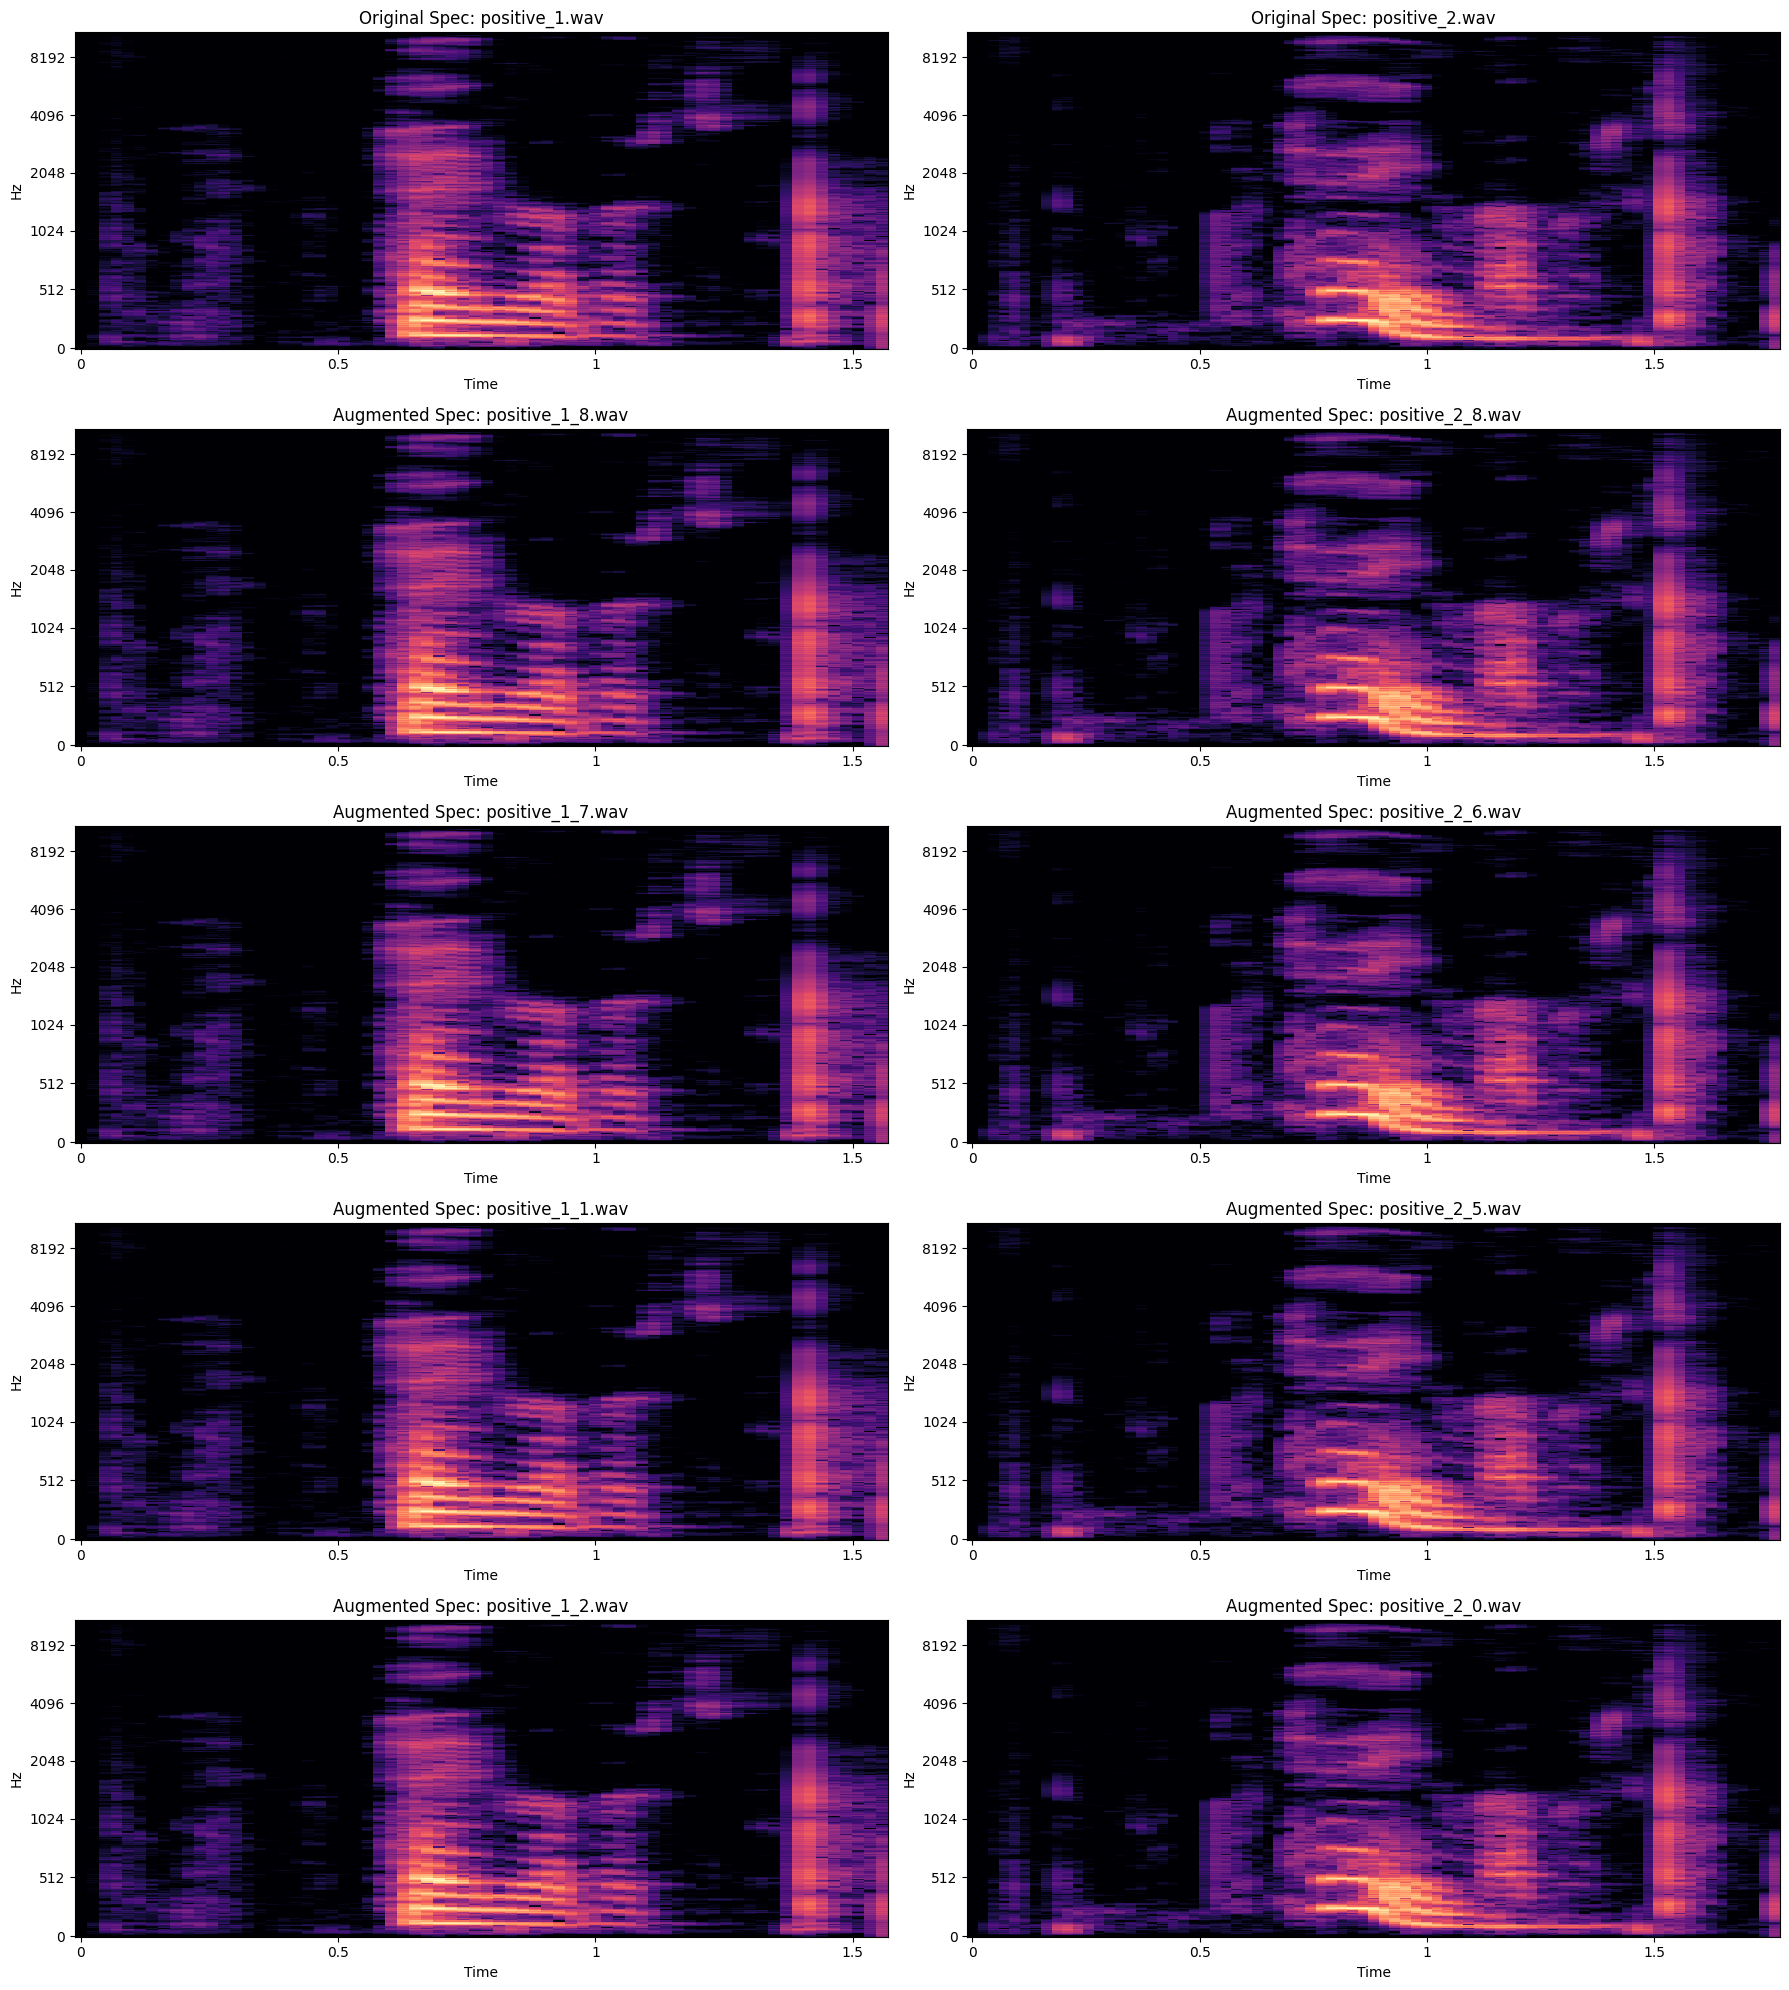

In [15]:


height = 4 * (x_axis + 1) # Adjusted height for better spectrogram aspect ratio
fig, ax = plt.subplots(x_axis + 1, len(wav_files), figsize=(18, height))

for j, file in enumerate(wav_files):
    # Load and calculate spectrogram for Original
    y_orig, S_orig, S_dB_orig , sr= get_mels_spectogram(file)
    file_name = file.split("/")[-1]
    
    # 1. Plot the Original Spectrogram (Top row)
    img = librosa.display.specshow(S_dB_orig, sr=sr, x_axis='time', y_axis='mel', ax=ax[0, j])
    ax[0, j].set_title(f"Original Spec: {file_name}")

    # Get generated samples
    k = file_name.replace(".wav", "")

    # 2. Plot Generated Spectrograms in the rows below
    for i_gen, gen_file_path in enumerate(gen_sample_dic[k]):
        row = i_gen + 1

        y_gen, S_gen, S_dB_gen, sr = get_mels_spectogram(file)
        gen_name = gen_file_path.split("/")[-1]

        # Plot the Augmented Spectrogram
        # Note: We use the 'magma' or 'viridis' colormap which is standard for specs
        librosa.display.specshow(S_dB_gen, sr=sr, x_axis='time', y_axis='mel', ax=ax[row, j], cmap='magma')
        
        ax[row, j].set_title(f"Augmented Spec: {gen_name}")

# Add a single colorbar at the end to show the Decibel scale
# fig.colorbar(img, ax=ax, format='%+2.0f dB') 

fig.tight_layout()
plt.show()

In [16]:

# # Calculate and plot spectrogram for a wav audio file
# def graph_spectrogram(wav_file):
#     rate, data = get_wav_info(wav_file)
#     nfft = 200 # Length of each window segment
#     fs = 8000 # Sampling frequencies
#     noverlap = 120 # Overlap between windows
#     nchannels = data.ndim
#     if nchannels == 1:
#         pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
#     elif nchannels == 2:
#         pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
#     return pxx

# # Load a wav file
# def get_wav_info(wav_file):
#     rate, data = wavfile.read(wav_file)
#     return rate, data

# # --- Your provided helper functions (slightly modified for axis support) ---

# def plot_into_ax(wav_file, ax_obj):
#     rate, data = wavfile.read(wav_file)
    
#     # Parameters from your original function
#     nfft = 200 
#     fs = rate  # Using actual rate from file for accuracy, or use 8000 as per your snippet
#     noverlap = 120 
    
#     # Handle Stereo/Mono
#     if data.ndim > 1:
#         data = data[:, 0]
    
#     # Plot using the specific axis object
#     pxx, freqs, bins, im = ax_obj.specgram(data, NFFT=nfft, Fs=fs, noverlap=noverlap, cmap='magma')
#     return im

# # --- Main Adaptation ---

# height = 4 * (x_axis + 1)
# fig, ax = plt.subplots(x_axis + 1, len(wav_files), figsize=(18, height))

# # Ensure ax is always 2D even if only one file or one row exists
# if len(wav_files) == 1:
#     ax = ax[:, np.newaxis]

# for j, file in enumerate(wav_files):
#     file_name = file.split("/")[-1]
    
#     # 1. Plot the Original Spectrogram (Top row)
#     plot_into_ax(file, ax[0, j])
#     ax[0, j].set_title(f"Original Spec: {file_name}")
#     ax[0, j].set_ylabel("Frequency (Hz)")

#     # Get generated samples dictionary key
#     k = file_name.replace(".wav", "")

#     # 2. Plot Generated Spectrograms in the rows below
#     for i_gen, gen_file_path in enumerate(gen_sample_dic[k]):
#         row = i_gen + 1
#         gen_name = gen_file_path.split("/")[-1]

#         # Plot the Augmented Spectrogram using the helper
#         plot_into_ax(gen_file_path, ax[row, j])
        
#         ax[row, j].set_title(f"Augmented Spec: {gen_name}")
#         ax[row, j].set_ylabel("Frequency (Hz)")
#         ax[row, j].set_xlabel("Time (s)")

# fig.tight_layout()
# plt.show()

/tmp/ipykernel_303199/1144336217.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


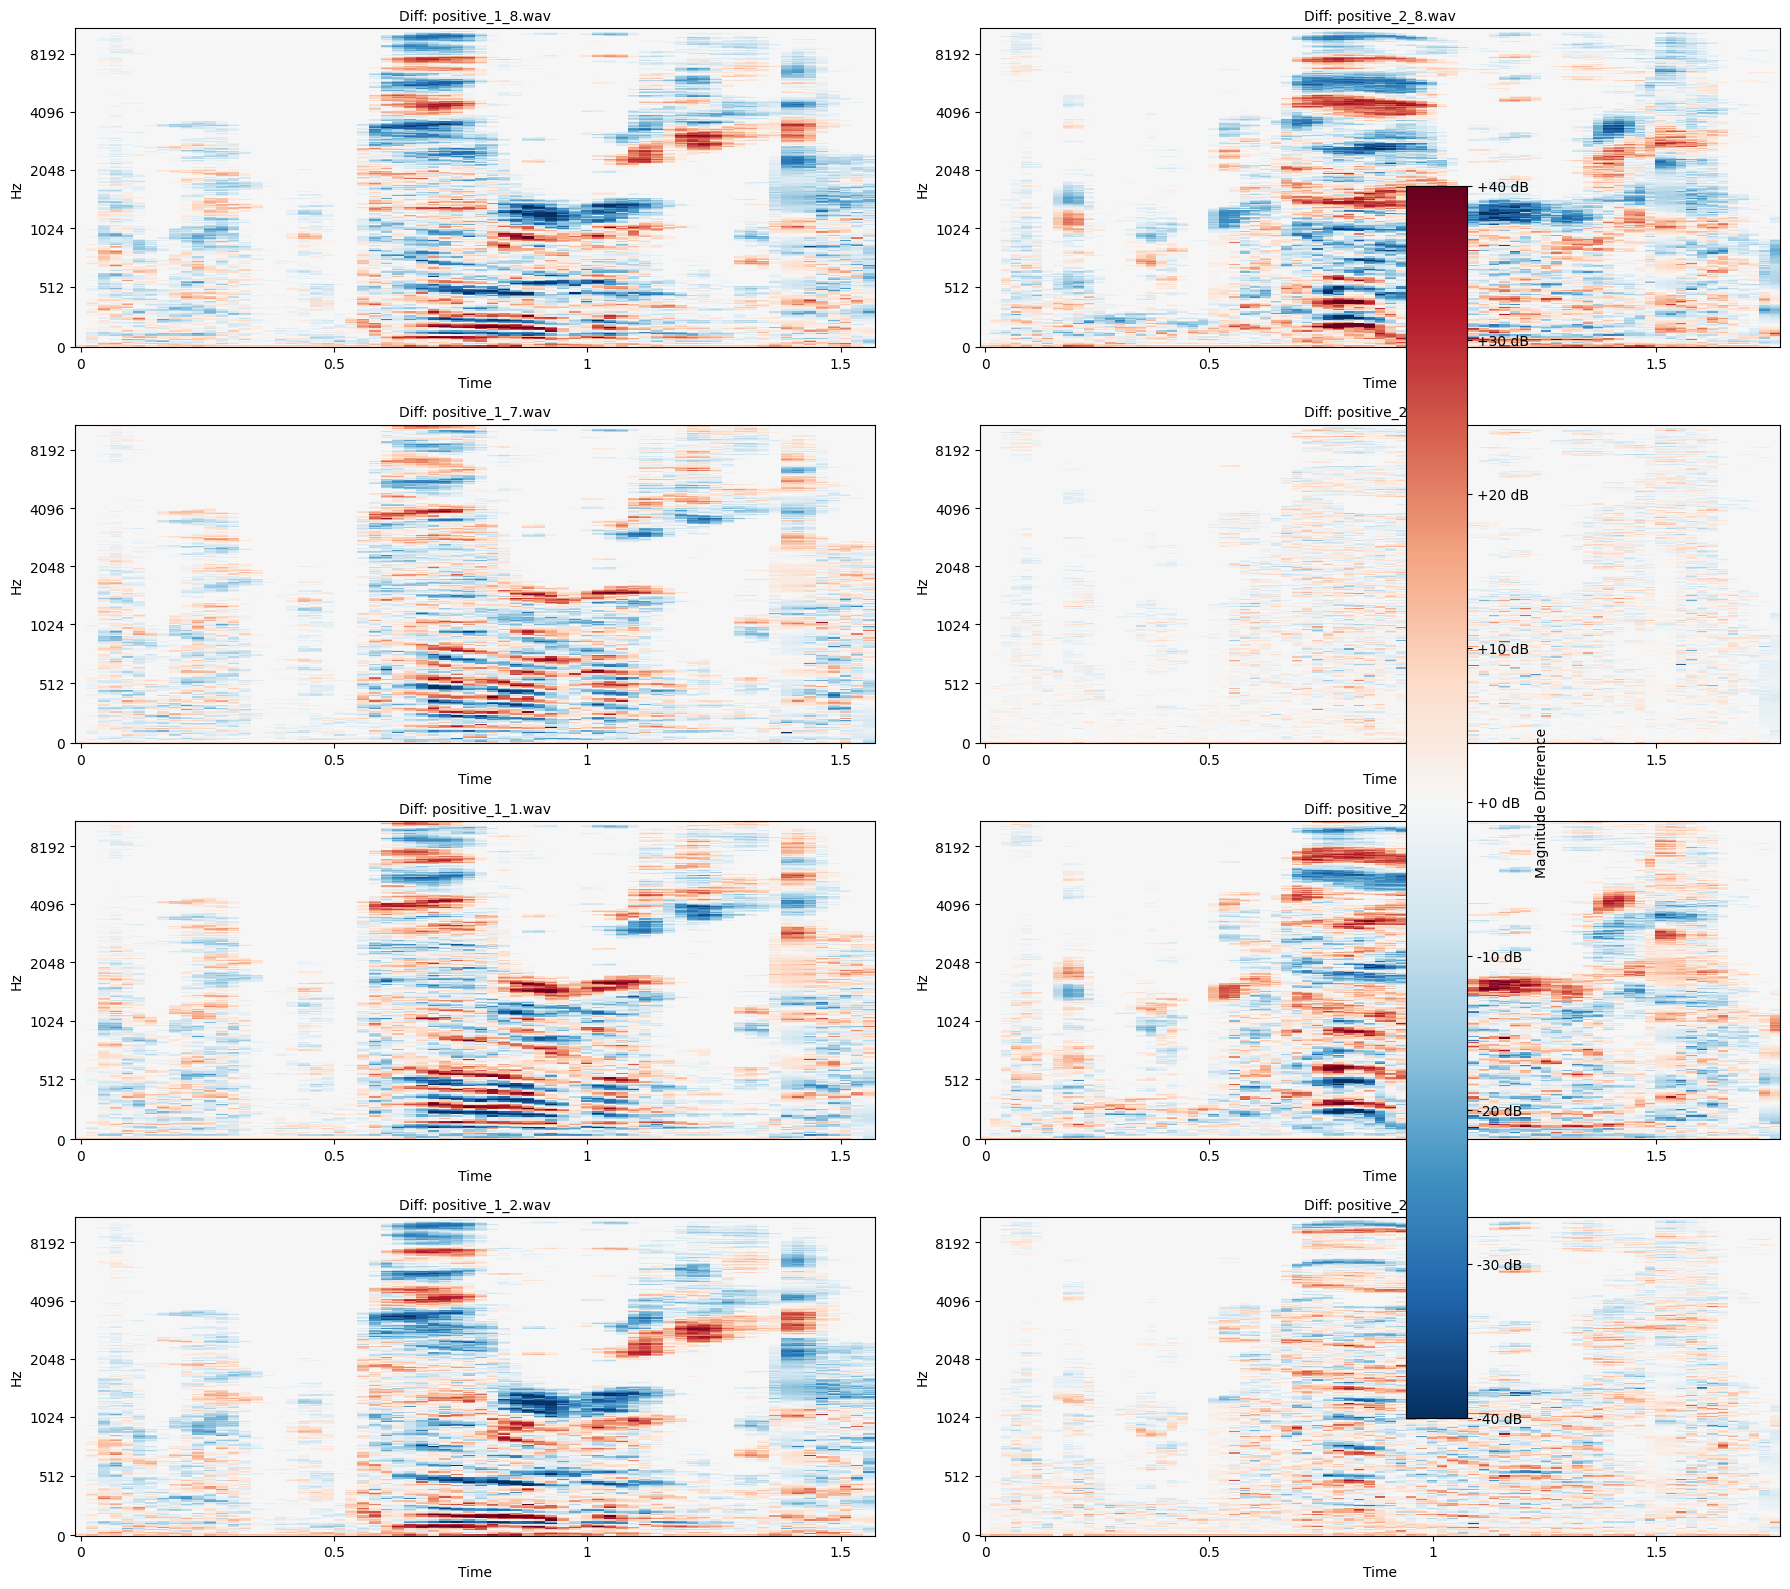

In [17]:

# Each subplot will show ONLY the difference map
fig, ax = plt.subplots(x_axis, len(wav_files), figsize=(18, 4 * x_axis))

# Ensure ax is 2D even if len(wav_files) == 1
if len(wav_files) == 1:
    ax = ax.reshape(-1, 1)

for j, file in enumerate(wav_files):
    # 1. Load and process Original (The Baseline)
    y_orig, S_orig, S_dB_orig, sr = get_mels_spectogram(file)

    # Get the generated filenames for this specific original
    k = file.split("/")[-1].replace(".wav", "")
    gen_audio_samples = gen_sample_dic[k]

    for i_gen in range(x_axis):
        # 2. Load and process Augmented
        gen_file_path = gen_audio_samples[i_gen]
        y_gen, S_gen, S_dB_gen , sr= get_mels_spectogram(gen_file_path)

        # --- ALIGNMENT (PADDING) ---
        # Find the max width between the two spectrograms
        max_width = max(S_dB_orig.shape[1], S_dB_gen.shape[1])
        
        # Pad both to the same width using -80dB as the "silent" floor
        S_dB_orig_pad = np.pad(S_dB_orig, ((0,0), (0, max_width - S_dB_orig.shape[1])), constant_values=-80)
        S_dB_gen_pad = np.pad(S_dB_gen, ((0,0), (0, max_width - S_dB_gen.shape[1])), constant_values=-80)

        # 3. CALCULATE DIFFERENCE
        # Result: Positive values mean "Added energy", Negative means "Lost energy"
        S_diff = S_dB_gen_pad - S_dB_orig_pad

        # Using 'RdBu_r' (Red-Blue reversed): 
        # RED = Frequency added by augmentation (like noise or higher pitch)
        # BLUE = Frequency lost or shifted away from the original spot
        img = librosa.display.specshow(S_diff, sr=sr, x_axis='time', y_axis='mel', 
                                       ax=ax[i_gen, j], cmap='RdBu_r', vmin=-40, vmax=40)
        
        gen_name = gen_file_path.split("/")[-1]
        ax[i_gen, j].set_title(f"Diff: {gen_name}", fontsize=10)

# Add a colorbar to the side of the last column to show the dB difference scale
fig.colorbar(img, ax=ax, format='%+2.0f dB', label='Magnitude Difference')

fig.tight_layout()
plt.show()

# Creating Dataset


Checking file ./Dataset/positive_real/positive_2.wav
---> 48000


/tmp/ipykernel_303199/683974996.py:11: MatplotlibDeprecationWarning: Passing the NFFT parameter of specgram() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
/home/n/.conda/envs/ai_dev/lib/python3.12/site-packages/matplotlib/axes/_axes.py:8280: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


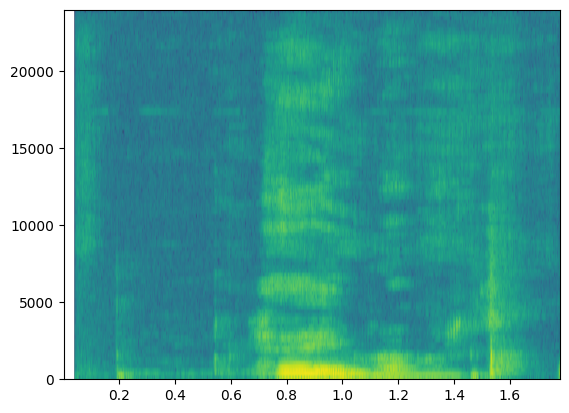

In [18]:
def graph_spectrogram(wav_file):
    rate, data = wavfile.read(wav_file)
    print("--->",rate)
    nfft = 200 # Length of each window segment
    fs = rate # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

print(f"Checking file {file}")
x = graph_spectrogram(file)

In [19]:
_, data = wavfile.read(backgrounds_files[0])
y_gen, sr = librosa.load(backgrounds_files[0])

S_gen = librosa.feature.melspectrogram(y=y_gen, sr=sr, hop_length=hop_length )
S_dB_gen = librosa.power_to_db(S_gen, ref=np.max)
print("Time steps in audio recording before spectrogram", data.shape)
print("Time steps in input after mel spectrogram", S_dB_gen.shape) # N_mel,frames
# print("Time steps in input after mel spectrogram", x.shape) # N_mel,frames

Time steps in audio recording before spectrogram (220500,)
Time steps in input after mel spectrogram (128, 216)


In [20]:
Tx = S_dB_gen.shape[1]
n_freq = S_dB_gen.shape[0] 
Ty = 105#400 # The number of time steps in the output of our model


In [21]:
IPython.display.Audio(file) # 1s audigo -> 85440 time steps


In [22]:
generated_files = [generated_positive_directory+"/"+f for f in os.listdir(generated_positive_directory) if f.endswith('.wav')]

IPython.display.Audio(backgrounds_files[50]) 

In [23]:
IPython.display.Audio(negative_files[3]) 

In [24]:

backgrounds = [AudioSegment.from_wav(backgrounds_directory+"/"+f) for f in os.listdir(backgrounds_directory) if f.endswith('.wav')]
negatives = [AudioSegment.from_wav(negative_directory+"/"+f ) for f in os.listdir(negative_directory) if f.endswith('.wav')]
positives = [AudioSegment.from_wav(generated_positive_directory+"/"+f) for f in os.listdir(generated_positive_directory) if f.endswith('.wav')]


In [25]:
print("background for  5s audio : ", len(backgrounds[0]))
for i, f in enumerate(positives):
    print(f"positive[{i}] for 1 second " , len(f))
    if i == 10:
        break
for i, f in enumerate(negatives):
    print(f"negative[{i}] for 1 second " , len(f))
    if i == 20:
        break

background for  5s audio :  5000
positive[0] for 1 second  1780
positive[1] for 1 second  1570
positive[2] for 1 second  1570
positive[3] for 1 second  1570
positive[4] for 1 second  1570
positive[5] for 1 second  1570
positive[6] for 1 second  1570
positive[7] for 1 second  1570
positive[8] for 1 second  1570
positive[9] for 1 second  1570
positive[10] for 1 second  1570
negative[0] for 1 second  360
negative[1] for 1 second  579
negative[2] for 1 second  407
negative[3] for 1 second  541
negative[4] for 1 second  655
negative[5] for 1 second  358
negative[6] for 1 second  552
negative[7] for 1 second  1337
negative[8] for 1 second  355
negative[9] for 1 second  600


We will be working with 5s input audio, being 5 seconds noise + 1 second positive/negative. We need to place 1 second positive + 1 second negative in the 5 seconds beckground without overlap, but for this, we need to make sure that the number of samples from both positive and negative are not higher than background's samples. Of course it will not be, but let's check.

In [26]:
max([len(f) for f in positives]) + max([len(f) for f in negatives]) #4657 -> almost 5000 from 5 seconds.

4657

Adding positives and negatives to the background without overlapping

In [27]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=5000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [28]:

def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    overlap = False 
    
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments: 
        if segment_start <= previous_end and segment_end >= previous_start: 
            overlap = True
            break

    return overlap

In [29]:
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time =get_random_time_segment(segment_ms)
    
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. To avoid an endless loop
    # we retry 5 times(≈ 2 lines)
    retry = 5 
    while is_overlapping(segment_time, previous_segments) and retry >= 0:
        segment_time = get_random_time_segment(segment_ms)
        retry = retry - 1

    # if last try is not overlaping, insert it to the background
    if not is_overlapping(segment_time, previous_segments):
        # Step 3: Append the new segment_time to the list of previous_segments (≈ 1 line)
        previous_segments.append(segment_time)
        # Step 4: Superpose audio segment and background
        new_background = background.overlay(audio_clip, position = segment_time[0])
    else:
        #print("Timeouted")
        new_background = background
        segment_time = (5000, 5000)
    
    return new_background, segment_time

In [30]:
np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(backgrounds[0], positives[0], [(3790, 4400)])
audio_clip.export("Dataset/tests/inserted_positive.wav", format="wav")
print("Segment Time: ", segment_time)
IPython.display.Audio("Dataset/tests/inserted_positive.wav")

Segment Time:  (1725, 3504)


sanity checks: 0.0 0.0 0.0


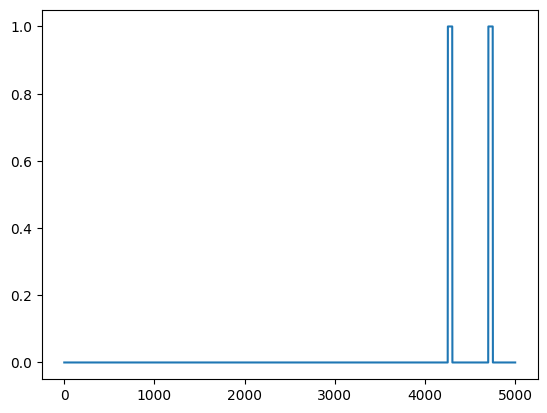

In [31]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 following labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    _, Ty = y.shape
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 5000.0)
    
    if segment_end_y < Ty:
        # Add 1 to the correct index in the background label (y)
        for i in range(segment_end_y + 1, segment_end_y + 51):
            if i <Ty:
                y[0, i] = 1
    
    return y

arr1 = insert_ones(np.zeros((1, 5000)), 4700)
plt.plot(insert_ones(arr1, 4251)[0,:])
print("sanity checks:", arr1[0][1333], arr1[0][634], arr1[0][635])

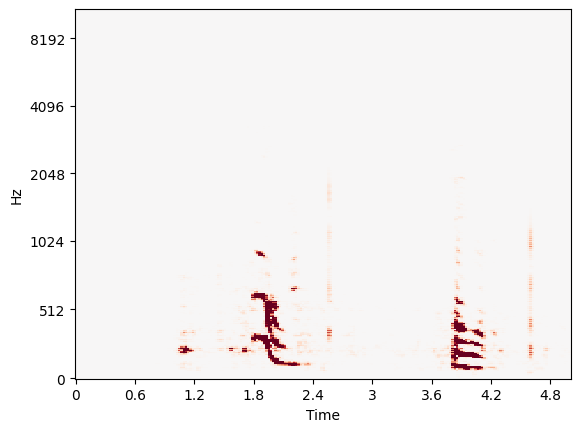

In [32]:
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

def create_training_example(background, activates, negatives, Ty, sample_number = 0, plot_ = False):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    Ty -- The number of time steps in the output

    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Make background quieter
    background = background - 20

    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 3)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for one_random_activate in random_activates:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, one_random_activate, previous_segments)
        
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y" at segment_end
        y =insert_ones(y, segment_end)

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
  
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export(f"Dataset/training_set/train_{sample_number}.wav", format="wav")
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    y_gen, S_gen, S_dB_gen, sr = get_mels_spectogram(f"Dataset/training_set/train_{sample_number}.wav")
    
    if plot_ :
        img = librosa.display.specshow(S_gen, sr=sr, x_axis='time', y_axis='mel', cmap='RdBu_r', vmin=-40, vmax=40)
    
    
    return S_gen, y

x, y = create_training_example(backgrounds[5], positives, negatives, Ty, plot_ = True)


In [33]:
IPython.display.Audio("./Dataset/training_set/train_0.wav")

In [ ]:
np.random.seed(4543)
nsamples = 10000
X = []
Y = []
for i in range(0, nsamples):
    if i%100 == 0:
        print(i)
    x, y = create_training_example(backgrounds[i % 2], positives, negatives, Ty, i)
    X.append(x.swapaxes(0,1))
    Y.append(y.swapaxes(0,1))

X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800


In [ ]:
import pickle

with open('X.pkl', 'wb') as f:
    pickle.dump(X, f)

with open('Y.pkl', 'wb') as f:
    pickle.dump(Y, f)

# Load
with open('X.pkl', 'rb') as f:
    X = pickle.load(f)

with open('Y.pkl', 'rb') as f:
    Y = pickle.load(f)